In [1]:
%load_ext autoreload

In [2]:
%autoreload
from npyx import *

npyx version 2.6.1 imported.


# Load Spike Data

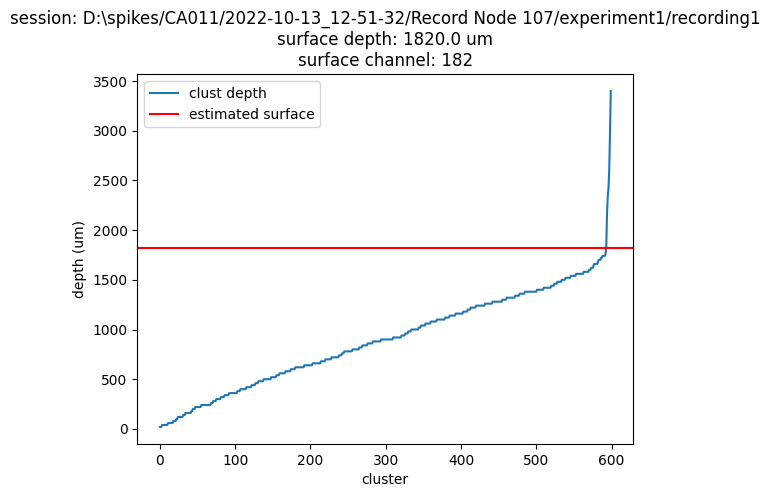

In [3]:
computer_name = os.environ['COMPUTERNAME']
if 'DESKTOP-HT3RNG1' in computer_name:
    data_path = 'D:\spikes'
else:
    data_path = 'X:\data\mpfc-pilot'
dp = f'{data_path}/CA011/2022-10-13_12-51-32/Record Node 107/experiment1/recording1'
#dp = f'{data_path}/CA011/2022-10-14_12-28-53/Record Node 107/experiment1/recording1'
clust = get_units(dp)
clust_info = get_units_info(dp)

# approximate brain surface by looking at where the units are
good_unit_depth = clust_info[clust_info.KSLabel=='good'].depth
surface_depth = np.sort(good_unit_depth)[np.argwhere(np.diff(good_unit_depth)>100)[0][0]]
plt.plot(np.sort(good_unit_depth),label='clust depth')
plt.axhline(surface_depth,color='r',label='estimated surface')
plt.xlabel('cluster')
plt.ylabel('depth (um)')
plt.legend()

# adjust depth to be relative to brain surface
clust_info['adj_depth'] = -(clust_info.depth - surface_depth)

# get channel of surface depth
cm = chan_map(dp, y_orig='tip', probe_version='1.0')
surface_channel = np.abs(np.vstack(cm)[:,2] - surface_depth).argmin()
plt.title(f'session: {dp}\nsurface depth: {surface_depth} um\nsurface channel: {surface_channel}');

In [5]:
# extract good cells
good = (clust_info.adj_depth > 0) & (clust_info.KSLabel == 'good') & (clust_info.fr > 1)
good_cells = clust_info.cluster_id[good].values
good_cells_info = clust_info.loc[good]
good_cells_info = good_cells_info.reset_index()
fs = 30e3

n good units: 242
n good spikes: 242


In [52]:
def get_sync_starts(dp):
    fn = os.path.join(dp,'sync_messages.txt')
    with open(fn) as f:
        lines = f.readlines()
        data = {}
        for i,line in enumerate(lines):
            l = line.split(':')
            data[l[0]] = int(l[1].strip())

    return data

def get_message_events(dp, fs=30000):

    # get clock start
    start_times = get_sync_starts(dp)
    ap_start = [start_times[s] for s in start_times if 'AP' in s]
    assert len(ap_start) > 0, f'No AP start time found!'
    start_time = ap_start[0]

    # text messages
    ts = np.load(f'{dp}/events/MessageCenter/sample_numbers.npy') - start_time # offset by recording start time
    txt = np.load(f'{dp}/events/MessageCenter/text.npy')
    txt = [t.decode('UTF-8') for t in txt]
    u,i = np.unique(ts,return_index=True)
    ts = ts[i] / fs # convert to seconds
    txt = [txt[j] for j in i]

    messages = {}
    for i,key in enumerate(txt):
        messages[key] = ts[i]


    return messages, start_time



In [57]:
messages, start_time = get_message_events(dp)
messages

{'starting robot wheel tests': 1009.0521666666667,
 't1': 1075.8188333333333,
 't2': 1092.7188333333334,
 't3 - 60s': 1119.3855,
 't4 - on-off 1hz 30 secs': 1195.8355,
 't5 - moved closer ran 30 s': 1277.5355,
 't6 - moved closer ran 60 s': 1324.6521666666667,
 'motor tests': 1402.2855,
 't1 - trigger puff for 30 seconds': 1427.6688333333334,
 't2 - moved closer and trigger puff 30 sec': 1477.2688333333333,
 '(didnt send messages when connected)': 1519.0188333333333,
 'ran motor low speed, close to mouse 60 s': 1634.0355,
 'baseline 60s': 1745.8021666666666}

In [75]:
event = 't6 - moved closer ran 60 s'
time_span = [messages[event]-30, messages[event]+30]
trains = [trn(dp, u, periods=[time_span])/fs for u in good_cells]
sorti = np.argsort(-good_cells_info.adj_depth).values
sorti

array([  3,   4,   0,   1,   2,   5,   6,   8,   7,  10,  11,   9,  12,
        13,  14,  15,  17,  19,  16,  18,  20,  27,  29,  26,  28,  23,
        25,  22,  24,  21,  30,  32,  31,  33,  38,  36,  40,  34,  35,
        37,  39,  41,  42,  47,  48,  46,  44,  43,  45,  49,  50,  52,
        62,  51,  53,  54,  57,  59,  56,  58,  61,  55,  63,  60,  70,
        72,  68,  71,  65,  67,  64,  66,  79,  74,  76,  69,  73,  75,
        77,  78,  81,  82,  80,  83,  84,  85,  88,  86,  87,  94,  95,
        93,  96,  91,  90,  89,  92, 100, 106, 105,  97,  99, 101, 103,
       104, 108, 111, 102,  98, 109, 112, 107, 110, 115, 116, 113, 114,
       117, 121, 120, 119, 118, 123, 124, 122, 126, 134, 133, 132, 131,
       129, 128, 130, 140, 127, 125, 141, 139, 142, 135, 137, 136, 144,
       138, 143, 147, 145, 146, 148, 149, 153, 154, 151, 152, 150, 155,
       157, 162, 159, 160, 167, 156, 158, 161, 166, 165, 163, 164, 173,
       176, 168, 169, 170, 172, 174, 175, 171, 177, 179, 180, 19

TypeError: only integer scalar arrays can be converted to a scalar index

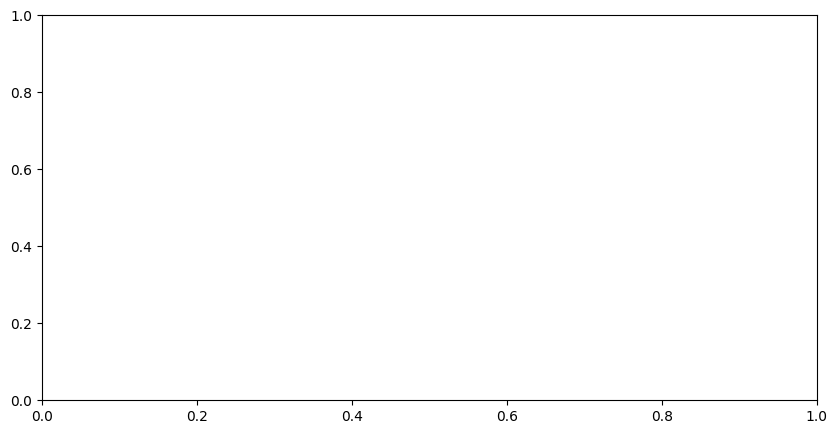

In [74]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.eventplot(trains[sorti],color='k');
ax.axvline(messages[event],color='r')

In [ ]:
# load messages
# load the messages
start_time = 168801936 # from sync_messages.txt
ts = np.load(f'{dp}/events/MessageCenter/sample_numbers.npy') - start_time # offset by recording start time
txt = np.load(f'{dp}/events/MessageCenter/text.npy')
txt = [t.decode('UTF-8') for t in txt]
u,i = np.unique(ts,return_index=True)
ts = ts[i] / fs / 60 # convert to minutes
txt = [txt[j] for j in i]

# Plot and analyze ISI dist

NameError: name 'ts' is not defined

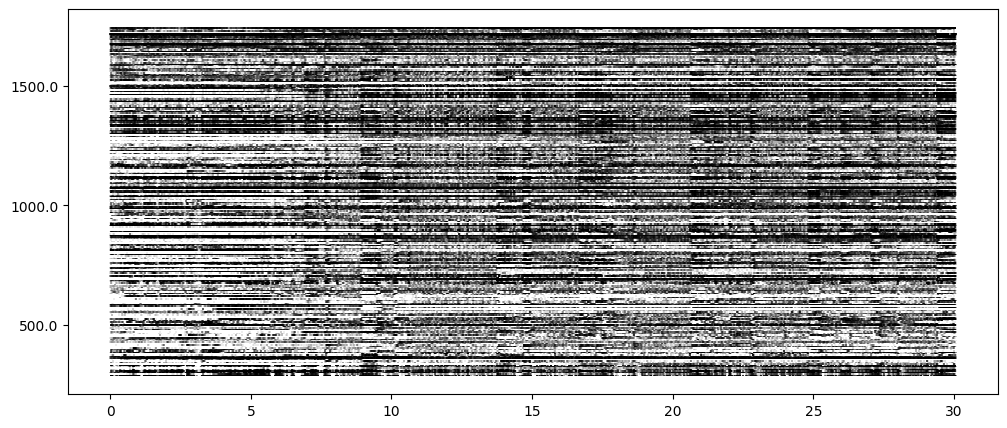

In [11]:
# sort cells by depth
Y = good_cells_info.adj_depth
X = spikes
spks_sort = [x for _, x in sorted(zip(Y, X), key=lambda pair: pair[0])]
fig,ax = plt.subplots(1,1,figsize=(12,5))
_ = ax.eventplot(spks_sort,colors='k',linewidths=0.1)
plt.axis('tight')
tickl = np.unique(np.sort(good_cells_info.adj_depth)[(np.sort(good_cells_info.adj_depth) % 500) == 0])
ticks = [np.argmax(np.sort(good_cells_info.adj_depth) >= i) for i in tickl]
ax.yaxis.set_ticks(ticks)
ax.yaxis.set_ticklabels(tickl)
for i,t in enumerate(ts):
    ax.axvline(t,color='r')
    ax.text(t,-5,str(i),color='r')
    print(f'{i}) {txt[i]}')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Depth (um from dura)')
ax.set_xlim([0,30])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().invert_yaxis()
#fig.savefig('spike_raster.pdf')

WilcoxonResult(statistic=3318.0, pvalue=9.729993047975963e-05)


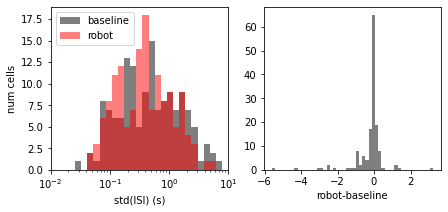

In [ ]:
# for each cell, compute std of ISIs before and after 15 minutes
pre_std = []
post_std = []
for u in spks:
    pre_std.append(np.nanstd(np.diff(u[u<15]) * 60))
    post_std.append(np.nanstd(np.diff(u[u>15]) * 60))
pre_std = np.array(pre_std)
post_std = np.array(post_std)
mn,mx = 0.01,10
bins = np.logspace(np.log10(mn),np.log10(mx),30)
fig,ax = plt.subplots(1,2,figsize=(7,3))
ax[0].hist(pre_std,bins,color='k',alpha=0.5,label='baseline')
ax[0].hist(post_std,bins,color='r',alpha=0.5,label='robot')
ax[0].set_xscale('log')
ax[0].set_xlim([mn,mx])
ax[0].set_xlabel('std(ISI) (s)')
ax[0].set_ylabel('num cells')
ax[0].legend()

ax[1].hist(post_std-pre_std,50,color='k',alpha=0.5)
ax[1].set_xlabel('robot-baseline')

from scipy.stats import wilcoxon
print(wilcoxon(post_std,pre_std))

# Synchronize data streams
First load timestamps for relevant files

In [ ]:
ts = {'ap': np.load(os.path.join(dp,'continuous','Neuropix-PXI-100.ProbeA-AP','timestamps.npy')),\
      'lfp': np.load(os.path.join(dp,'continuous','Neuropix-PXI-100.ProbeA-LFP','timestamps.npy')),\
      'nidaq': np.load(os.path.join(dp,'continuous','NI-DAQmx-103.PXI-6133','timestamps.npy'))}

Load raw binary data

In [ ]:
def load_binary_chunk(dp, times, channels=np.arange(384), filt_key='lowpass', scale=True, verbose=False):
    dp = Path(dp)
    meta = read_metadata(dp)
    fname = Path(dp)/meta['lowpass']['binary_relative_path'][2:]
    
    fs = meta[filt_key]['sampling_rate']
    Nchans=meta[filt_key]['n_channels_binaryfile']
    bytes_per_sample=2
    
    assert len(times)==2
    assert times[0]>=0
    assert times[1]<meta['recording_length_seconds']
    
    # Format inputs
    ignore_ks_chanfilt = True
    channels=assert_chan_in_dataset(dp, channels, ignore_ks_chanfilt)
    t1, t2 = int(np.round(times[0]*fs)), int(np.round(times[1]*fs))
    
    vmem=dict(psutil.virtual_memory()._asdict())
    chunkSize = int(fs*Nchans*bytes_per_sample*(times[1]-times[0]))
    if verbose:
        print('Used RAM: {0:.1f}% ({1:.2f}GB total).'.format(vmem['used']*100/vmem['total'], vmem['total']/1024/1024/1024))
        print('Chunk size:{0:.3f}MB. Available RAM: {1:.3f}MB.'.format(chunkSize/1024/1024, vmem['available']/1024/1024))
    if chunkSize>0.9*vmem['available']:
        print('WARNING you are trying to load {0:.3f}MB into RAM but have only {1:.3f}MB available.\
              Pick less channels or a smaller time chunk.'.format(chunkSize/1024/1024, vmem['available']/1024/1024))
        return
    
    # Get chunk from binary file
    with open(fname, 'rb') as f_src:
        # each sample for each channel is encoded on 16 bits = 2 bytes: samples*Nchannels*2.
        byte1 = int(t1*Nchans*bytes_per_sample)
        byte2 = int(t2*Nchans*bytes_per_sample)
        bytesRange = byte2-byte1

        f_src.seek(byte1)

        bData = f_src.read(bytesRange)
        
    # Decode binary data
    # channels on axis 0, time on axis 1
    assert len(bData)%2==0
    rc = np.frombuffer(bData, dtype=np.int16) # 16bits decoding
    rc = rc.reshape((int(t2-t1), Nchans)).T
    rc = rc[:-1,:] # remove sync channel
    
    # Scale data
    if scale:
        rc = rc * meta['bit_uV_conv_factor'] # convert into uV
    
    return rc

In [ ]:
meta = read_metadata(dp)
fs = metadata(dp)['lowpass']['sampling_rate']
dat = load_binary_chunk(dp,[0,30*60],filt_key='lowpass')

WARNING you are trying to load 3295.898MB into RAM but have only 279.250MB available.              Pick less channels or a smaller time chunk.


75000

In [ ]:
# mdn = np.vstack([np.median(dat[i,:]) for i in range(dat.shape[0])])
dat = dat - np.median(dat,axis=1)[:,np.newaxis]

NameError: name 'dat' is not defined

In [ ]:
offset = 100
fs = 2500
w = int(np.round(fs*0.5))
start = int(np.round(fs*15*60))
rng = range(start,start+w)
plt_dat = dat[:,rng]
plt_offsets = np.arange(0, plt_dat.shape[0]*offset, offset)
plt_dat+=plt_offsets[:,np.newaxis]

fig,ax = plt.subplots(1,1,figsize=(10,20))
_ = plt.plot(plt_dat.T)

IndexError: index 2250000 is out of bounds for axis 1 with size 750000

In [ ]:
get_meta

NameError: name 'get_meta' is not defined

In [ ]:
from sys import getsizeof
getsizeof(dat)

16